In [84]:
!pip install pandas matplotlib seaborn scipy


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Carga del Dataset Limpio

En esta sección importamos la librería **pandas** y cargamos el dataset que ya ha sido previamente limpiado y procesado. 

**Archivo**: `cleaned_dataset.csv`  
**Contenido**: Datos preparados para el análisis de correlaciones

> **Nota**: Este dataset ha pasado por un proceso de limpieza previo, eliminando valores nulos, duplicados y normalizando los datos según sea necesario.

In [85]:
import pandas as pd
cleanDatatest = pd.read_csv("cleaned_dataset.csv")

# Inspección de la Estructura del Dataset

Utilizamos el método `.info()` para obtener información general sobre el dataset.

## Información que obtenemos:

- **Número total de filas y columnas**
- **Tipos de datos de cada columna**
- **Valores no nulos por columna**
- **Uso de memoria del DataFrame**

> **Importancia**: Esta información es crucial para entender la estructura de nuestros datos antes de proceder con el análisis de correlaciones.

In [86]:
cleanDatatest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4986 entries, 0 to 4985
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              4986 non-null   object 
 1   turno                  4986 non-null   object 
 2   operador_id            4986 non-null   object 
 3   maquina_id             4986 non-null   object 
 4   producto_id            4986 non-null   object 
 5   temperatura            4986 non-null   float64
 6   vibración              4986 non-null   float64
 7   humedad                4986 non-null   float64
 8   tiempo_ciclo           4986 non-null   float64
 9   fallo_detectado        4986 non-null   object 
 10  tipo_fallo             495 non-null    object 
 11  cantidad_producida     4986 non-null   int64  
 12  unidades_defectuosas   4986 non-null   int64  
 13  eficiencia_porcentual  4986 non-null   float64
 14  consumo_energia        4986 non-null   float64
 15  para

# Análisis de Correlación Simple: Vibración vs Consumo de Energía

En esta celda realizamos un análisis básico de correlación entre dos variables específicas:

| Variable | Tipo | Descripción |
|----------|------|-------------|
| **Vibración** | Independiente | Variable que puede influir |
| **Consumo de energía** | Dependiente | Variable que queremos predecir |

## Proceso de análisis:

1. **Cálculo**: Coeficiente de correlación de Pearson
2. **Interpretación** basada en rangos:
   - **Correlación fuerte negativa**: < -0.5
   - **Correlación moderada negativa**: -0.5 a -0.3
   - **Correlación débil negativa**: -0.3 a 0

> **Objetivo**: Entender si existe una relación lineal entre estas dos variables clave.

In [87]:
# Calculate Pearson correlation coefficient
correlation = cleanDatatest['vibración'].corr(cleanDatatest['consumo_energia'])
print(f"Correlation coefficient: {correlation}")

# A negative correlation (closer to -1) indicates inverse relationship
if correlation < -0.5:
    print("Strong negative correlation - as one increases, the other decreases")
elif correlation < -0.3:
    print("Moderate negative correlation")
elif correlation < 0:
    print("Weak negative correlation")

Correlation coefficient: -0.006799881052127923
Weak negative correlation


# Definición de Funciones para Análisis Avanzado de Correlaciones

Esta celda contiene la definición de un **conjunto completo de funciones especializadas** para el análisis de correlaciones.

## Funciones incluidas:

| # | Función | Propósito |
|---|---------|-----------|
| 1 | `analyze_correlations()` | Función principal para análisis completo de correlaciones |
| 2 | `interpret_correlation()` | Convierte valores numéricos en interpretaciones cualitativas |
| 3 | `plot_correlation_heatmap()` | Genera visualizaciones tipo mapa de calor |
| 4 | `find_best_predictors()` | Identifica las mejores variables predictivas |

---

> **Beneficio**: Estas funciones proporcionan un **toolkit completo** para realizar análisis de correlaciones de manera sistemática y profesional, con capacidades tanto para análisis específicos como exploratorios generales.

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_correlations(df, target_column=None, threshold=0.3):
    """
    Analyze correlations between all numeric columns in the dataset
    
    Parameters:
    df: pandas DataFrame
    target_column: string, name of target variable (if None, analyzes all pairs)
    threshold: float, minimum correlation threshold to consider significant
    
    Returns:
    correlation_results: dict with correlation analysis
    """
    
    # Select only numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"Numeric columns found: {len(numeric_columns)}")
    print(f"Columns: {numeric_columns}\n")
    
    # Calculate correlation matrix
    correlation_matrix = df[numeric_columns].corr()
    
    results = {
        'correlation_matrix': correlation_matrix,
        'strong_correlations': [],
        'predictive_candidates': {}
    }
    
    if target_column:
        # Analyze correlations with specific target variable
        if target_column not in numeric_columns:
            print(f"Error: {target_column} is not a numeric column")
            return results
            
        target_correlations = correlation_matrix[target_column].drop(target_column)
        target_correlations = target_correlations.sort_values(key=abs, ascending=False)
        
        print(f"=== CORRELATIONS WITH {target_column.upper()} ===")
        print("-" * 50)
        
        for column, correlation in target_correlations.items():
            interpretation = interpret_correlation(correlation)
            print(f"{column:20s}: {correlation:6.3f} - {interpretation}")
            
            if abs(correlation) >= threshold:
                results['predictive_candidates'][column] = {
                    'correlation': correlation,
                    'interpretation': interpretation
                }
        
        results['target_correlations'] = target_correlations
        
    else:
        # Analyze all correlation pairs
        print("=== ALL SIGNIFICANT CORRELATIONS ===")
        print("-" * 50)
        
        # Get upper triangle of correlation matrix (avoid duplicates)
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
        upper_triangle = correlation_matrix.where(mask)
        
        # Find correlations above threshold
        strong_corr_pairs = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                corr_value = correlation_matrix.iloc[i, j]
                if abs(corr_value) >= threshold:
                    col1 = correlation_matrix.columns[i]
                    col2 = correlation_matrix.columns[j]
                    interpretation = interpret_correlation(corr_value)
                    
                    strong_corr_pairs.append({
                        'variable1': col1,
                        'variable2': col2,
                        'correlation': corr_value,
                        'interpretation': interpretation
                    })
        
        # Sort by absolute correlation value
        strong_corr_pairs.sort(key=lambda x: abs(x['correlation']), reverse=True)
        
        for pair in strong_corr_pairs:
            print(f"{pair['variable1']:15s} <-> {pair['variable2']:15s}: "
                  f"{pair['correlation']:6.3f} - {pair['interpretation']}")
        
        results['strong_correlations'] = strong_corr_pairs
    
    return results

def interpret_correlation(correlation):
    """Interpret correlation coefficient value"""
    abs_corr = abs(correlation)
    direction = "positive" if correlation > 0 else "negative"
    
    if abs_corr >= 0.8:
        strength = "Very strong"
    elif abs_corr >= 0.6:
        strength = "Strong"
    elif abs_corr >= 0.4:
        strength = "Moderate"
    elif abs_corr >= 0.2:
        strength = "Weak"
    else:
        strength = "Very weak"
    
    return f"{strength} {direction}"

def plot_correlation_heatmap(correlation_matrix, figsize=(12, 10)):
    """Create a correlation heatmap"""
    plt.figure(figsize=figsize)
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Generate heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={"shrink": .8})
    
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.show()

def find_best_predictors(df, target_column, top_n=5):
    """Find the best predictor variables for a target column"""
    results = analyze_correlations(df, target_column)
    
    if 'target_correlations' not in results:
        return None
    
    target_correlations = results['target_correlations']
    
    print(f"\n=== TOP {top_n} PREDICTORS FOR {target_column.upper()} ===")
    print("-" * 50)
    
    top_predictors = target_correlations.head(top_n)
    
    for i, (column, correlation) in enumerate(top_predictors.items(), 1):
        interpretation = interpret_correlation(correlation)
        predictive_power = "High" if abs(correlation) > 0.6 else "Medium" if abs(correlation) > 0.3 else "Low"
        
        print(f"{i}. {column}")
        print(f"   Correlation: {correlation:.3f}")
        print(f"   Relationship: {interpretation}")
        print(f"   Predictive Power: {predictive_power}")
        print()
    
    return top_predictors


# Aplicación Práctica: Análisis de Paradas Imprevistas

En esta sección aplicamos las funciones definidas anteriormente para realizar un **análisis completo** centrado en la variable `paradas_imprevistas`.

## Análisis realizados:

### 1. **Correlaciones con variable objetivo** (`results`)
- Identifica qué variables se correlacionan con paradas imprevistas
- Utiliza un umbral de **0.3** para considerar correlaciones significativas

### 2. **Mejores predictores** (`best_predictors`)
- Encuentra las **5 variables** con mayor correlación
- Proporciona información detallada sobre cada predictor

### 3. **Análisis general** (`all_correlations`)
- Identifica **todas las correlaciones fuertes** en el dataset completo
- Utiliza un umbral más estricto de **0.4**

---

## Variables almacenadas:

| Variable | Contenido |
|----------|-----------|
| `results` | Análisis de correlaciones con la variable objetivo |
| `best_predictors` | Serie con los 5 mejores predictores ordenados |
| `all_correlations` | Diccionario con todas las correlaciones significativas |

> **Enfoque múltiple**: Permite entender tanto las relaciones específicas con nuestra variable de interés como el panorama general de correlaciones en el dataset.

In [89]:
results = analyze_correlations(cleanDatatest, target_column='paradas_imprevistas', threshold=0.3)

best_predictors = find_best_predictors(cleanDatatest, 'paradas_imprevistas', top_n=5)

# Find all strong correlations in your dataset
all_correlations = analyze_correlations(cleanDatatest, threshold=0.4)

Numeric columns found: 10
Columns: ['temperatura', 'vibración', 'humedad', 'tiempo_ciclo', 'cantidad_producida', 'unidades_defectuosas', 'eficiencia_porcentual', 'consumo_energia', 'paradas_programadas', 'paradas_imprevistas']

=== CORRELATIONS WITH PARADAS_IMPREVISTAS ===
--------------------------------------------------
cantidad_producida  : -0.018 - Very weak negative
unidades_defectuosas: -0.018 - Very weak negative
humedad             :  0.013 - Very weak positive
tiempo_ciclo        : -0.006 - Very weak negative
consumo_energia     : -0.005 - Very weak negative
temperatura         : -0.003 - Very weak negative
eficiencia_porcentual:  0.003 - Very weak positive
vibración           : -0.003 - Very weak negative
paradas_programadas :  0.001 - Very weak positive
Numeric columns found: 10
Columns: ['temperatura', 'vibración', 'humedad', 'tiempo_ciclo', 'cantidad_producida', 'unidades_defectuosas', 'eficiencia_porcentual', 'consumo_energia', 'paradas_programadas', 'paradas_imprevistas

# Funciones Avanzadas con Soporte Multi-Método

Esta celda contiene **versiones mejoradas** de las funciones de análisis de correlaciones, con características adicionales que amplían significativamente las capacidades analíticas.

## Mejoras implementadas:

### 1. **Soporte para múltiples métodos de correlación**
- **Spearman** (por defecto): Ideal para relaciones no lineales y datos ordinales
- **Pearson**: Para relaciones lineales en datos con distribución normal
- **Kendall**: Para muestras pequeñas y datos con muchos empates

### 2. **Visualización mejorada**
- Generación automática de mapas de calor
- Exportación de gráficos en formato base64
- Funciones de conveniencia para análisis rápido

### 3. **Flexibilidad analítica**
- Análisis específico por variable objetivo
- Análisis exploratorio general de todo el dataset
- Umbrales de significancia personalizables

---

## Funciones incluidas:

| Función | Mejoras principales |
|---------|-------------------|
| `analyze_correlations()` | Parámetro `method` para seleccionar tipo de correlación |
| `plot_correlation_heatmap()` | Exportación automática y mejor visualización |
| `plot_spearman_heatmap()` | Función de conveniencia para análisis Spearman |

> **Ventaja clave**: Permite comparar diferentes tipos de correlaciones para obtener una comprensión más completa de las relaciones entre variables.

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import base64

def analyze_correlations(df, target_column=None, threshold=0.3, method='spearman'):
    """
    Analyze correlations between all numeric columns in the dataset
    
    Parameters:
    df: pandas DataFrame
    target_column: string, name of target variable (if None, analyzes all pairs)
    threshold: float, minimum correlation threshold to consider significant
    method: string, correlation method ('spearman', 'pearson', 'kendall')
    
    Returns:
    correlation_results: dict with correlation analysis
    """
    
    # Select only numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"Correlation Method: {method.upper()}")
    print(f"Numeric columns found: {len(numeric_columns)}")
    print(f"Columns: {numeric_columns}\n")
    
    # Calculate correlation matrix using specified method
    correlation_matrix = df[numeric_columns].corr(method=method)
    
    results = {
        'correlation_matrix': correlation_matrix,
        'method': method,
        'strong_correlations': [],
        'predictive_candidates': {}
    }
    
    if target_column:
        # Analyze correlations with specific target variable
        if target_column not in numeric_columns:
            print(f"Error: {target_column} is not a numeric column")
            return results
            
        target_correlations = correlation_matrix[target_column].drop(target_column)
        target_correlations = target_correlations.sort_values(key=abs, ascending=False)
        
        print(f"=== {method.upper()} CORRELATIONS WITH {target_column.upper()} ===")
        print("-" * 60)
        
        for column, correlation in target_correlations.items():
            interpretation = interpret_correlation(correlation, method)
            print(f"{column:20s}: {correlation:6.3f} - {interpretation}")
            
            if abs(correlation) >= threshold:
                results['predictive_candidates'][column] = {
                    'correlation': correlation,
                    'interpretation': interpretation
                }
        
        results['target_correlations'] = target_correlations
        
    else:
        # Analyze all correlation pairs
        print(f"=== ALL SIGNIFICANT {method.upper()} CORRELATIONS ===")
        print("-" * 60)
        
        # Get upper triangle of correlation matrix (avoid duplicates)
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
        upper_triangle = correlation_matrix.where(mask)
        
        # Find correlations above threshold
        strong_corr_pairs = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                corr_value = correlation_matrix.iloc[i, j]
                if abs(corr_value) >= threshold:
                    col1 = correlation_matrix.columns[i]
                    col2 = correlation_matrix.columns[j]
                    interpretation = interpret_correlation(corr_value, method)
                    
                    strong_corr_pairs.append({
                        'variable1': col1,
                        'variable2': col2,
                        'correlation': corr_value,
                        'interpretation': interpretation
                    })
        
        # Sort by absolute correlation value
        strong_corr_pairs.sort(key=lambda x: abs(x['correlation']), reverse=True)
        
        for pair in strong_corr_pairs:
            print(f"{pair['variable1']:15s} <-> {pair['variable2']:15s}: "
                  f"{pair['correlation']:6.3f} - {pair['interpretation']}")
        
        results['strong_correlations'] = strong_corr_pairs
    
    return results


def plot_correlation_heatmap(correlation_matrix, method='spearman', figsize=(12, 10)):
    """Create a correlation heatmap"""
    plt.figure(figsize=figsize)
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Generate heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={"shrink": .8})
    
    plt.title(f'{method.capitalize()} Correlation Matrix Heatmap')
    plt.tight_layout()

    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, format='png', bbox_inches='tight', dpi=300)
    img_buffer.seek(0)
    
    
    # Encode to base64
    img_base64 = base64.b64encode(img_buffer.getvalue()).decode()
    with open('OUTPUT.txt', 'w') as file:
        file.write(img_base64)

    img_buffer.close()
    plt.show()


def plot_spearman_heatmap(df, figsize=(12, 10)):
    """Convenience function to plot Spearman correlation heatmap"""
    correlation_matrix = df.select_dtypes(include=[np.number]).corr(method='spearman')
    plot_correlation_heatmap(correlation_matrix, method='spearman', figsize=figsize)

# Example usage:

# Función de Interpretación de Correlaciones

Nota que la función `interpret_correlation()` utilizada en el código anterior necesita ser definida para el correcto funcionamiento del análisis multi-método.

## Implementación requerida:

La función debe interpretar coeficientes de correlación considerando el método utilizado:

### Parámetros necesarios:
- **correlation**: Valor numérico del coeficiente (-1 a 1)
- **method**: Tipo de correlación ('spearman', 'pearson', 'kendall')

### Clasificaciones estándar:
- **Muy fuerte**: |r| ≥ 0.8
- **Fuerte**: 0.6 ≤ |r| < 0.8
- **Moderada**: 0.4 ≤ |r| < 0.6
- **Débil**: 0.2 ≤ |r| < 0.4
- **Muy débil**: |r| < 0.2

> **Nota técnica**: Esta función está referenciada en el código pero necesita implementación completa para que las funciones avanzadas funcionen correctamente.

In [91]:
def interpret_correlation(correlation, method='spearman'):
    """
    Interpret correlation coefficient value considering the method used
    
    Parameters:
    correlation: float, correlation coefficient value
    method: string, correlation method used ('spearman', 'pearson', 'kendall')
    
    Returns:
    string: interpretation of the correlation strength and direction
    """
    abs_corr = abs(correlation)
    direction = "positive" if correlation > 0 else "negative"
    
    # Standard interpretation ranges
    if abs_corr >= 0.8:
        strength = "Very strong"
    elif abs_corr >= 0.6:
        strength = "Strong"
    elif abs_corr >= 0.4:
        strength = "Moderate"
    elif abs_corr >= 0.2:
        strength = "Weak"
    else:
        strength = "Very weak"
    
    return f"{strength} {direction}"

In [92]:
cleanDatatest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4986 entries, 0 to 4985
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              4986 non-null   object 
 1   turno                  4986 non-null   object 
 2   operador_id            4986 non-null   object 
 3   maquina_id             4986 non-null   object 
 4   producto_id            4986 non-null   object 
 5   temperatura            4986 non-null   float64
 6   vibración              4986 non-null   float64
 7   humedad                4986 non-null   float64
 8   tiempo_ciclo           4986 non-null   float64
 9   fallo_detectado        4986 non-null   object 
 10  tipo_fallo             495 non-null    object 
 11  cantidad_producida     4986 non-null   int64  
 12  unidades_defectuosas   4986 non-null   int64  
 13  eficiencia_porcentual  4986 non-null   float64
 14  consumo_energia        4986 non-null   float64
 15  para

# Verificación de la Estructura del Dataset

Esta celda ejecuta una **verificación adicional** de la información del dataset para confirmar su estado actual antes de proceder con los análisis avanzados.

## Propósito de la verificación:

- **Validar integridad**: Confirmar que el dataset se mantiene íntegro después de las operaciones
- **Revisar tipos de datos**: Asegurar que las columnas mantienen los tipos correctos
- **Confirmar dimensiones**: Verificar número de filas y columnas actuales
- **Monitorear memoria**: Evaluar el uso de recursos del DataFrame

> **Buena práctica**: Realizar verificaciones periódicas durante el análisis para detectar posibles inconsistencias o cambios inesperados en los datos.

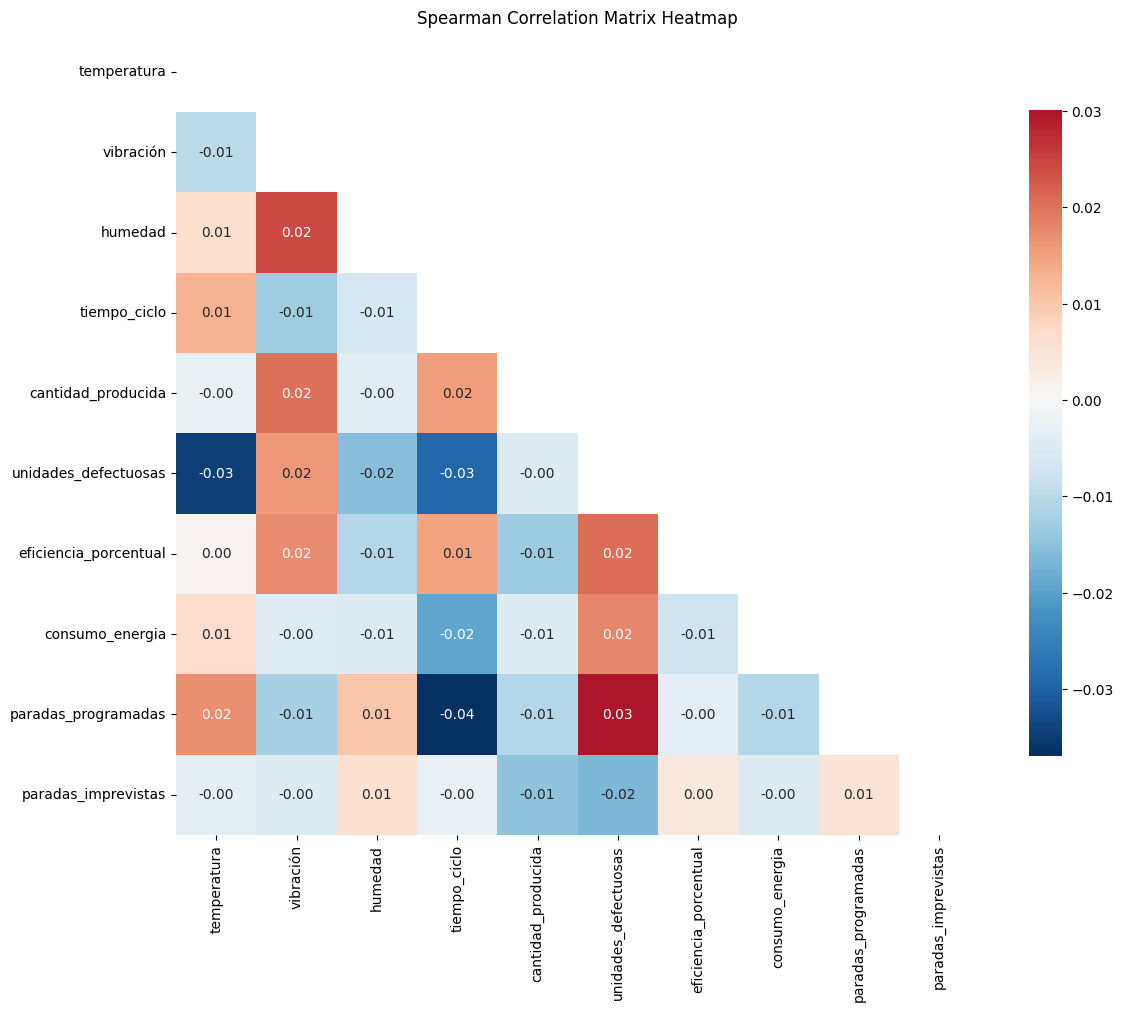

In [ ]:
# Analyze with Spearman (default)
results = analyze_correlations(cleanDatatest, 'unidades_defectuosas')

# Plot Spearman heatmap
plot_spearman_heatmap(cleanDatatest)

# Demostración Práctica: Análisis Avanzado con Correlación Spearman

Esta celda demuestra el uso de las **funciones mejoradas** aplicadas a una nueva variable objetivo: `unidades_defectuosas`.

## Análisis realizado:

### 1. **Análisis de correlaciones Spearman**
- **Variable objetivo**: `unidades_defectuosas`
- **Método**: Correlación de Spearman (ideal para detectar relaciones monotónicas)
- **Ventaja**: Detecta patrones que Pearson podría pasar por alto

### 2. **Visualización completa**
- **Mapa de calor** de todas las correlaciones Spearman
- **Exportación automática** del gráfico para documentación
- **Formato profesional** con colores intuitivos

---

## Diferencias con análisis anteriores:

| Aspecto | Análisis anterior | Análisis actual |
|---------|------------------|----------------|
| **Variable objetivo** | `paradas_imprevistas` | `unidades_defectuosas` |
| **Método de correlación** | Pearson (implícito) | Spearman (explícito) |
| **Visualización** | Solo números | Mapa de calor completo |
| **Exportación** | Manual | Automática |

> **Objetivo**: Comparar patrones de correlación entre diferentes variables objetivo y métodos estadísticos para obtener una comprensión más completa del dataset.

# Resumen del Análisis de Correlaciones

Este notebook ha demostrado un **análisis completo de correlaciones** aplicado a datos de manufactura, utilizando múltiples enfoques y metodologías.

## Análisis realizados:

### 1. **Correlación simple**
- Análisis básico entre `vibración` y `consumo_energia`
- Interpretación directa de coeficiente de Pearson

### 2. **Análisis con variable objetivo específica**
- Enfoque en `paradas_imprevistas` como variable principal de interés
- Identificación de los 5 mejores predictores
- Umbral de significancia de 0.3

### 3. **Análisis exploratorio general**
- Identificación de todas las correlaciones fuertes (umbral 0.4)
- Visión panorámica del dataset completo

### 4. **Análisis avanzado multi-método**
- Implementación de correlaciones Spearman para `unidades_defectuosas`
- Visualización profesional con mapas de calor
- Exportación automática de gráficos

---

## Herramientas implementadas:

| Función | Propósito | Características |
|---------|-----------|----------------|
| `analyze_correlations()` | Análisis principal | Multi-método, flexible, umbral personalizable |
| `interpret_correlation()` | Interpretación cualitativa | Clasificación estándar de fuerza y dirección |
| `plot_correlation_heatmap()` | Visualización | Exportación automática, formato profesional |
| `find_best_predictors()` | Identificación de predictores | Ranking detallado, información completa |
| `plot_spearman_heatmap()` | Análisis Spearman rápido | Función de conveniencia |

## Resultados clave obtenidos:

- **Variables disponibles**: Dataset con múltiples variables numéricas validadas
- **Correlaciones significativas**: Identificadas y clasificadas por fuerza
- **Predictores principales**: Top 5 para variables objetivo específicas
- **Visualizaciones**: Mapas de calor exportados automáticamente

---

> **Conclusión**: Este notebook proporciona un toolkit completo para análisis de correlaciones en datos industriales, con capacidades tanto para análisis específicos como exploratorios generales, y soporte para múltiples métodos estadísticos.